# De-Reverberation Initial Investigation

Optionally install tqdm if you don't have it...

In [1]:
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

import librosa as lr
from librosa.display import *
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

import numpy as np

from tqdm import tqdm_notebook as tqdm

import random
from IPython.display import Audio

In [2]:
import torchaudio as ta
import torchaudio.functional as taf

In [3]:
db = lambda x: lr.amplitude_to_db(x)

In [4]:
def plot_spec(sig,sr=22050, channel=None):
    if type(sig) is torch.Tensor:
        sig = sig.squeeze().numpy()
    if channel != None:
        sig = sig[:,channel].squeeze()
    spec = db(abs(lr.stft(sig))) 
    specshow(spec, x_axis='time', y_axis='mel', sr=sr)

In [5]:
data = Path("data/")
speech = data/'clean-speech'
irs = data/'impulse-responses'
noise = data/'noise'

In [18]:
noises = noise.ls()
noise_ex, sr = ta.load(noises[0])

In [34]:
speech_ex,speech_sr = ta.load(speech.ls()[0])

In [35]:
speech_sr

16000

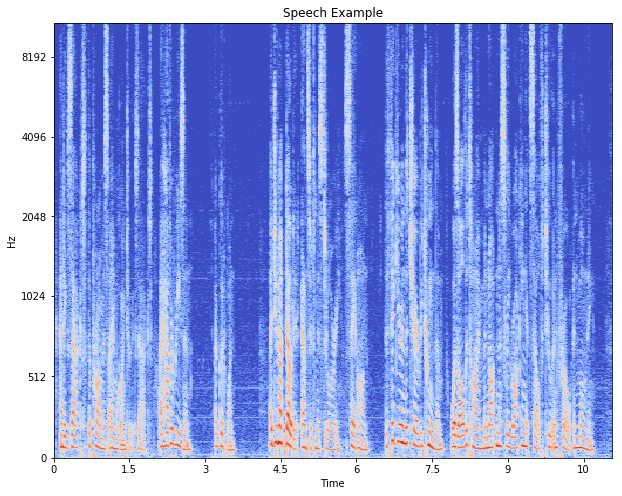

In [112]:
plot_spec(speech_ex)
plt.title("Speech Example")
Audio(speech_ex, rate=sr)

### TODO: Load IRs at correct sample rate. Speech @16i, IR@48k must be same to work well

In [74]:
ir_ex, sr = ta.load(irs.ls()[0])

In [75]:
ir_ex = ta.transforms.Resample(sr, speech_sr)(ir_ex)

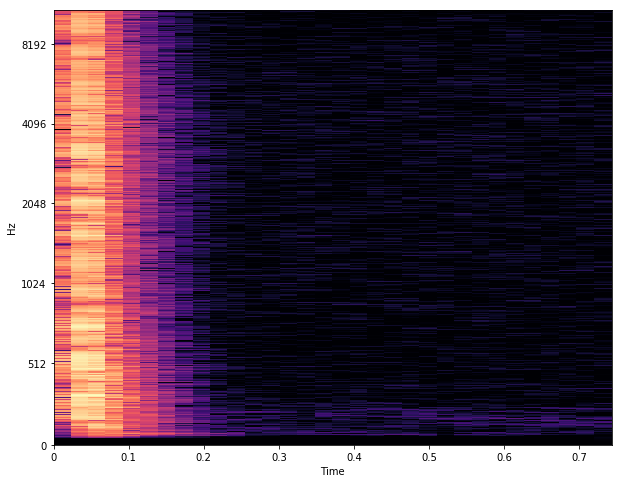

In [81]:
plot_spec(ir_ex[3,:])

In [30]:
ir_ex.shape

torch.Size([4, 48000])

In [149]:
reverbed_ex = np.convolve(speech_ex.squeeze().numpy(), ir_ex[0,:].squeeze().numpy())

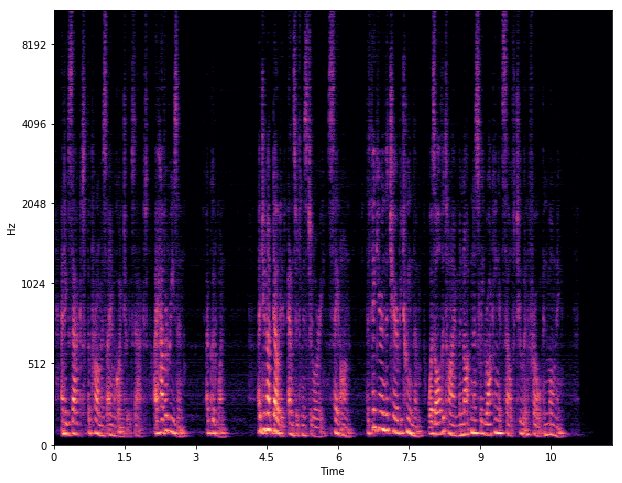

In [152]:
plot_spec(reverbed_ex)
ipd.Audio(reverbed_ex, rate=sr)

### Transforms

In [89]:
n,sr =ta.load(noises[0])

In [96]:
n.shape[1]

42805291

In [123]:
nzs, srs = zip(*[ta.load(x) for x in tqdm(noise.ls(), desc='Loading Noises...')])

In [82]:
class Noise(object):
    def __init__(self, noise_path, noise_sr=None, db_mean=-12, db_sd=3):
        self.noises, self.srs = zip(*[ta.load(x) for x in tqdm(noise_path.ls(), desc='Loading Noises...')])
        if noise_sr:
            self.noises = [ta.transforms.Resample(self.srs[i], noise_sr)(self.noises[i]) for i in 
                           tqdm(range(len(self.noises)), desc='Resampling Noises...')]
            
        self.db_dist = (db_mean, db_sd)
        
    def __call__(self, speech):
        db = np.random.normal(self.db_dist[0], self.db_dist[1])
        amp = lr.db_to_amplitude(db)
        n = random.choice(self.noises)
        if speech.shape[-1] < n.shape[-1]:
            return speech + amp * n[:,:speech.shape[-1]]
        else:
            return speech[:,:n.shape[-1]] + amp * n

class Reverb(object):
    def __init__(self, ir_path, ir_sr=None, ir_mono=True):
        self.irs, self.srs = zip(*[ta.load(x) for x in tqdm(ir_path.ls(), desc='Loading Impulse Responses...')])
        if ir_sr:
            self.irs = [ta.transforms.Resample(self.srs[i], ir_sr)(self.irs[i]) for i in 
                        tqdm(range(len(self.irs)), desc='Resampling Impulse Responses...')]
        if ir_mono:
            self.irs = [x[0,:] for x in self.irs]
    
    def __call__(self, speech):
        ir = random.choice(self.irs)
        # TODO: replace this with torch.conv1d
        return torch.Tensor(np.convolve(speech.squeeze().numpy(), ir.squeeze().numpy())[:speech.shape[-1]]).unsqueeze(0)

class RandomCrop(object):
    def __init__(self, length, no_rand=False):
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, speech):
        if self.no_rand:
            start = 0
        else:
            start = random.randint(0, abs(speech.shape[-1]-self.crop_len))
            
        if speech.shape[-1] > self.crop_len:
            return speech[:,start:start+self.crop_len]
        else:
            retval = torch.zeros((1,self.crop_len))
            retval[:,0:speech.shape[-1]] = speech
            return retval

### Question: noise->convolve or convolve->noise?

In [95]:
rev_tfms = transforms.Compose([Noise(Path('data/noise'), speech_sr, -6, 2), 
                               Reverb(Path('data/impulse-responses'), speech_sr)])
clean_tfms = transforms.Compose([RandomCrop(12*speech_sr)])

In [96]:
#%%writefile DeReverbDataset.py
class DeReverbDataset(Dataset):
    """
    Pytorch dataset for audio sequence to sequence tasks. 
    """
    def __init__(self, root_path, 
                 speech_path='clean-speech', 
                 ir_path='impulse-responses', 
                 noise_path='noise', rev_tfms=None, clean_tfms=None):
        self.rp = Path(root_path)
        self.speech_files = (self.rp/speech_path).ls()
        self.ir_files = (self.rp/ir_path).ls()
        self.noise_files = (self.rp/noise_path).ls()
        self.rev_tfms = rev_tfms
        self.clean_tfms = clean_tfms
        
    def __len__(self):
        return len(self.speech_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sfn = self.speech_files[idx]
        speech, ssr = ta.load(sfn)
        
        # Transforms change the clean speech, adding noise, reverb and 
        # other effects.
        if self.clean_tfms:
            speech = self.clean_tfms(speech)
            
        if self.rev_tfms:
            reverbed = self.rev_tfms(speech)
            
            
        
        reverbed = torch.Tensor(reverbed)
        speech = torch.Tensor(speech)
        sample = {'reverbed': reverbed, 'clean': speech}
        return sample

In [97]:
dataset = DeReverbDataset("data", rev_tfms=rev_tfms, clean_tfms=clean_tfms)

### Plot and Listen to Example Transformed Data

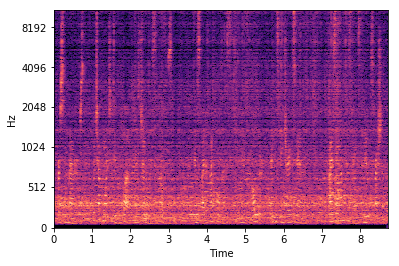

In [100]:
ex = dataset.__getitem__(random.choice(range(len(dataset))))

plot_spec(ex['reverbed'])
Audio(ex['reverbed'], rate=16000)

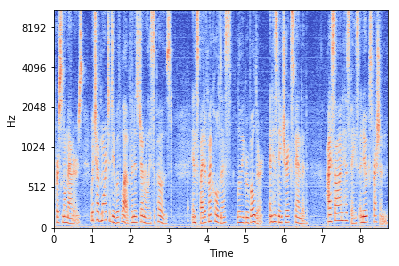

In [101]:
plot_spec(ex['clean'])
Audio(ex['clean'], rate=16000)

In [89]:
dl = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [92]:
%%time
next(iter(dl))

CPU times: user 14.9 ms, sys: 228 ms, total: 243 ms
Wall time: 3.13 s


{'reverbed': tensor([[[ 2.3855e-13, -3.9825e-11, -1.1873e-10,  ..., -9.9209e-04,
           -3.1096e-04,  1.9914e-04]],
 
         [[-1.0953e-08, -2.3864e-08,  1.6210e-08,  ...,  1.6044e-04,
            2.7200e-04,  2.8384e-04]],
 
         [[ 1.2842e-08,  3.9675e-08,  6.1029e-08,  ...,  3.2463e-04,
            2.2817e-04,  1.0853e-04]],
 
         [[-6.3831e-10, -2.9191e-10, -6.5586e-10,  ..., -1.9950e-04,
           -2.2024e-04, -2.3883e-04]]]),
 'clean': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -5.6305e-02,
            3.6926e-03,  3.6774e-02]],
 
         [[ 5.3131e-02,  6.3812e-02,  6.2103e-02,  ..., -2.4414e-04,
           -9.1553e-05,  3.9673e-04]],
 
         [[-5.0201e-02, -4.6448e-02, -3.8391e-02,  ..., -8.8501e-04,
           -8.2397e-04, -6.4087e-04]],
 
         [[-8.8501e-04, -5.7983e-04, -1.3123e-03,  ..., -5.2338e-02,
           -4.8401e-02, -4.0100e-02]]])}

# Model
(garbage for now)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class Recur_Reverb(nn.Module):
    def __init__(self, hidden_dim):
        super(Recur_Reverb, self,).__init__()
        self.lstm = nn.LSTM(1, hidden_dim, batch_first=True)
        
        self.l_out = nn.Linear(in_features=hidden_dim, out_features=1, bias=False)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        x, (_,_) = self.lstm(x)
        
        print(x.shape)
        x = x.view(x.shape[0], -1)
        
        x = self.l_out(x)
        return x

In [ ]:
n_epochs = 5

hid_dim = 128
net = Recur_Reverb(hid_dim).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-3)

losses = []
for i in tqdm(range(n_epochs)):
    epoch_loss = 0
    net.train()
    for batchid,batch in tqdm(enumerate(dl)):
        inputs = batch['reverbed'].cuda()
        targets = batch['clean'].cuda()
        print(inputs.shape)
        
        
        #print(f'target: {target.shape}')
        #print(f'outsig: {outsig.shape}')
        outputs = net(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.detach().numpy()
        
    print(epoch_loss)
    losses.append(epoch_loss/len(dl))

In [27]:
a = torch.zeros((4,20,128))
a.shape

torch.Size([4, 20, 128])

In [28]:
a.view(-1,128)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [53]:
lengths = []
for clip in tqdm(speech.ls()):
    s, fs = lr.load(clip, sr=None)
    lengths.append(len(s))